<a href="https://colab.research.google.com/github/erick-huang15/Food-Sales-Predictions/blob/main/Food_Sale_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
path = '/content/drive/MyDrive/CD: Project/sales_predictions.csv'
data = pd.read_csv(path)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [43]:
data.isna().sum() # this is to check the missing values in the dataset

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [44]:
data.duplicated().sum() # this is to check if there are any duplicate data

0

In [45]:
data.info() # this is to check the types of data in the datasets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [46]:
for col in data: #this is to loop through the dataset, explore, and see what changes are necessary
  print(data[col].value_counts())
  print('\n\n')

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64



12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.275      2
7.685      1
9.420      1
6.520      1
5.400      1
Name: Item_Weight, Length: 415, dtype: int64



Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64



Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat 

Medium    2793 
Small     2388
High       932
Name: Outlet_Size, dtype: int64 -> ordinal encode (check)



Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64 -> change LF, Reg (check)


Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64



In [47]:
data['Outlet_Establishment_Year'] = data['Outlet_Establishment_Year'].astype('object') # this is to change the dtype of Outlet_Etablishment_Year

In [48]:
replace_fc = {'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'} # this is to fix the inconsistent data in fat content
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace(replace_fc)
data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [49]:
outlet_size_replace = {'High':2,'Medium':1,'Small':0} # this is to ordinal encode Outlet_Size to small = 1, medium = 2, high = 3
data['Outlet_Size'].replace(outlet_size_replace,inplace=True)
data['Outlet_Size'].value_counts()

1.0    2793
0.0    2388
2.0     932
Name: Outlet_Size, dtype: int64

In [50]:
outlet_location_replace = {'Tier 3':3,'Tier 2':2,'Tier 1':1} # this to to ordinal encode outlet_location_type
data['Outlet_Location_Type'].replace(outlet_location_replace,inplace=True)
data['Outlet_Location_Type'].value_counts()

3    3350
2    2785
1    2388
Name: Outlet_Location_Type, dtype: int64

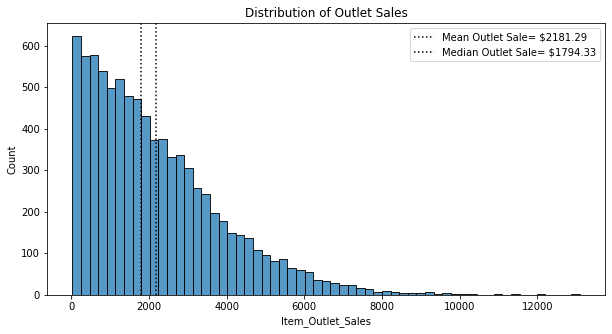

In [80]:
fig, ax = plt.subplots(figsize=(10,5))

## Plot histogram
sns.histplot(data=data, x='Item_Outlet_Sales', ax=ax)
ax.set(title='Distribution of Outlet Sales');

## Annotating mean and median
mean_price = data['Item_Outlet_Sales'].mean()
ax.axvline(mean_price,color='k', ls=':', 
           label=f"Mean Outlet Sale= ${round(mean_price,2)}");

med_price = data['Item_Outlet_Sales'].median()
ax.axvline(med_price,color='k', ls=':', 
           label=f"Median Outlet Sale= ${round(med_price,2)}");

ax.legend();

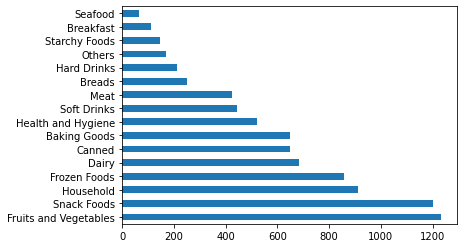

In [78]:
item_type = data['Item_Type'].value_counts()
item_type.plot(kind='barh')

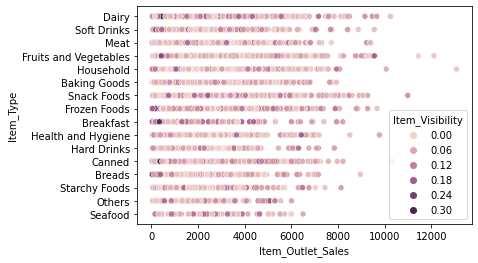

In [79]:
sns.scatterplot(data=data, x='Item_Outlet_Sales', y='Item_Type',hue='Item_Visibility')

In [51]:
X = data.drop(columns= ['Item_Identifier', 'Item_Outlet_Sales']) # Train-Test Split
y = data['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [52]:
# this is to instantiate column selectors
cat_select = make_column_selector(dtype_include='object')
num_select = make_column_selector(dtype_include='number')

In [53]:
# this is to impute the missing values in Item_Weight and Outlet_Size. 
# both are float and numeric data
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

scaler = StandardScaler() # this is to scale the data so that we can make calculations or comparisons
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

In [54]:
# Setup the pipelines for the numeric and categorical data
num_processor = make_pipeline(mean_imputer, scaler)

cat_processor = make_pipeline(freq_imputer, ohe)

In [55]:
# Setup the tuples to pair the processors with the make column selectors
num_tuple = (num_processor, num_select)

cat_tuple = (cat_processor, cat_select)

In [56]:
# Instantiate the make column transformer
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')

In [57]:
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f41e3d73250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.mak

In [58]:
# Fit the column transformer on the X_train
X_train_processed = col_transformer.fit(X_train)

In [59]:
# Extract the feature names from one hot encoder
cat_feature_names = col_transformer.named_transformers_['pipeline-2']\
                          .named_steps['onehotencoder']\
                          .get_feature_names_out(cat_select(X_train))

cat_feature_names

array(['Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Establishment_Year_1985', 'Outlet_Establishment_Year_1987',
       'Outlet_Establishment_Year_1997', 'Outlet_Establishment_Year_1998',
       'Outlet_Establishment_Year_1999

In [60]:
## get final col names which are num features + cat features
final_cols = num_select(X_train) + list(cat_feature_names)
final_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Item_Fat_Content_Low Fat',
 'Item_Fat_Content_Regular',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Identifier_OUT010',
 'Outlet_Identifier_OUT013',
 'Outlet_Identifier_OUT017',
 'Outlet_Identifier_OUT018',
 'Outlet_Identifier_OUT019',
 'Outlet_Identifier_OUT027',
 'Outlet_Identifier_OUT035',
 'Outlet_Identifier_OUT045',
 'Outlet_Identifier_OUT046',
 'Outlet_Identifier_OUT049',
 'Outlet_Establishment_Year_1985',
 'Outlet_Establishment_Year_1987',
 'Outlet_Establishment_Year_1997',
 'Outlet_Establishment_Year_1998',
 'Outlet_Establishmen

In [61]:
# Transform the X_train and the X_test
X_train_transformed = col_transformer.transform(X_train)

X_test_transformed = col_transformer.transform(X_test)

In [62]:
# Change the X_train and X_test transformed columns to a dataframe
X_train_output = pd.DataFrame(X_train_transformed, columns = final_cols)

X_test_output = pd.DataFrame(X_test_transformed, columns = final_cols)

In [63]:
# View the first five rows of the X_train transformed dataframe
X_train_output.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Establishment_Year_1998,Outlet_Establishment_Year_1999,Outlet_Establishment_Year_2002,Outlet_Establishment_Year_2004,Outlet_Establishment_Year_2007,Outlet_Establishment_Year_2009,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.817249,-0.712775,1.828109,0.407785,1.084948,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.556340,-1.291052,0.603369,0.407785,1.084948,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.131512,1.813319,0.244541,0.407785,-1.384777,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.169219,-1.004931,-0.952591,-1.291630,-0.149914,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.528819,-0.965484,-0.336460,0.000000,-0.149914,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [64]:
X_train_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      6392 non-null   float64
 1   Item_Visibility                  6392 non-null   float64
 2   Item_MRP                         6392 non-null   float64
 3   Outlet_Size                      6392 non-null   float64
 4   Outlet_Location_Type             6392 non-null   float64
 5   Item_Fat_Content_Low Fat         6392 non-null   float64
 6   Item_Fat_Content_Regular         6392 non-null   float64
 7   Item_Type_Baking Goods           6392 non-null   float64
 8   Item_Type_Breads                 6392 non-null   float64
 9   Item_Type_Breakfast              6392 non-null   float64
 10  Item_Type_Canned                 6392 non-null   float64
 11  Item_Type_Dairy                  6392 non-null   float64
 12  Item_Type_Frozen Foo

Your first task is to build a linear regression model to predict sales.

Build a linear regression model.
Evaluate the performance of your model based on r^2.
Evaluate the performance of your model based on rmse.

In [65]:
base_ohe_tuple = (ohe, cat_select)
base_scaler_tuple = (scaler, num_select)

base_transformer = make_column_transformer(base_scaler_tuple, base_ohe_tuple, remainder='passthrough')

In [66]:
# instantiate a baseline model using the 'mean' strategy
dummy = DummyRegressor(strategy='mean')
# put your ColumnTransformer and the baseline model into a pipeline

base_pipe = make_pipeline(base_transformer, dummy)
# fit your pipe onto the training data
base_pipe.fit(X_train_output, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f41e3d73250>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f41e3d73490>)])),
                ('dummyregressor', DummyRegressor())])

In [67]:
def eval_model(true, pred):
  mae = mean_absolute_error(true, pred)
  mse = mean_squared_error(true, pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(true, pred)

  print(f'MAE: {mae:,.2f} \n MSE: {mse:,.2f} \n RMSE: {rmse:,.2f} \n R2: {r2:,.2f} ')
# and prints all 4 metrics

In [68]:
# MAE, MSE, RMSE and R2 on the baseline model for both the train and test data
print('Train Evaluation')
eval_model(y_train, base_pipe.predict(X_train_output))

print('\n Test Evaluation') 
eval_model(y_test, base_pipe.predict(X_test_output))

Train Evaluation
MAE: 1,360.22 
 MSE: 2,959,455.70 
 RMSE: 1,720.31 
 R2: 0.00 

 Test Evaluation
MAE: 1,326.12 
 MSE: 2,772,144.46 
 RMSE: 1,664.98 
 R2: -0.00 


In [69]:
lin_reg = make_pipeline(base_transformer, LinearRegression())
lin_reg.fit(X_train_output, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f41e3d73250>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f41e3d73490>)])),
                ('linearregression', LinearRegression())])

In [70]:
print('Train Evaluation')
eval_model(y_train, lin_reg.predict(X_train_output))

print('\n Test Evaluation')
eval_model(y_test, lin_reg.predict(X_test_output))

Train Evaluation
MAE: 847.11 
 MSE: 1,297,745.48 
 RMSE: 1,139.19 
 R2: 0.56 

 Test Evaluation
MAE: 804.67 
 MSE: 1,195,654.21 
 RMSE: 1,093.46 
 R2: 0.57 


Your second task is to build a regression tree model to predict sales.

Build a simple regression tree model.
Compare the performance of your model based on r^2.
Compare the performance of your model based on rmse.  

In [71]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_output, y_train)

RandomForestRegressor(random_state=42)

In [72]:
rf_train_score = rf.score(X_train_output, y_train)
rf_test_score = rf.score(X_test_output, y_test)
print(rf_train_score)
print(rf_test_score)

0.938143550908484
0.5622665258544643


In [73]:
max_depth_range = list(range(2,36))

r2=[]
for n in max_depth_range:
  best_tree = RandomForestRegressor(max_depth = n, random_state = 42)
  best_tree.fit(X_train_output, y_train)
  score = best_tree.score(X_test_output, y_test)
  r2.append(score)

Text(0, 0.5, 'r2')

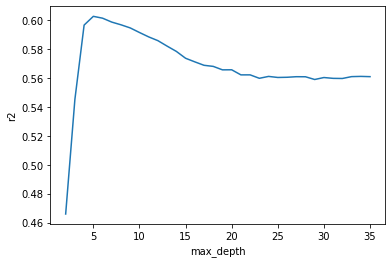

In [74]:
plt.plot(max_depth_range, r2)
plt.plot()
plt.xlabel('max_depth')
plt.ylabel('r2')

In [75]:
rand_tree_5 = RandomForestRegressor(max_depth=5, random_state=42) # the best depth is 5 because we want to maximize the training score in comparison to the linear model the max training score was 56. 
rand_tree_5.fit(X_train_output, y_train)
train_5_score = rand_tree_5.score(X_train_output, y_train)
test_5_score = rand_tree_5.score(X_test_output, y_test)
print(train_5_score)
print(test_5_score)

0.6105547865064987
0.6026818747563221


In [76]:
best_tree = RandomForestRegressor(max_depth=5)
best_tree_pipe = make_pipeline(base_transformer, best_tree)
                               
best_tree_pipe.fit(X_train_output, y_train)

print('Train Evaluation')

eval_model(y_train, best_tree_pipe.predict(X_train_output))

print('\n Test Evaluation')

eval_model(y_test, best_tree_pipe.predict(X_test_output))

Train Evaluation
MAE: 755.50 
 MSE: 1,153,666.83 
 RMSE: 1,074.09 
 R2: 0.61 

 Test Evaluation
MAE: 728.85 
 MSE: 1,094,746.13 
 RMSE: 1,046.30 
 R2: 0.60 


### Recommendation: 

Based on the training score: Linear regressor scored 0.56 and 0.57. In comparison to RandomForestRegressor, it scored 0.61 and 0.60. Given that the RandomForestRegressor scored higher, the recommendation will be to use RandomForestRegressor as the regression model to predict sales. 